## Exploring a Kaggle Competition Dataset for Binary Classification with LLM Fine-Tuning

In this post, we dive into a Kaggle competition dataset designed for binary classification tasks. The dataset is pristine—there are **no missing values** across any columns, ensuring a smooth preprocessing journey. It comprises **30 distinct numerical features**, accompanied by a **binary target** variable that defines the classification objective.
Our goal is to fine-tune an LLM , exploring its ability to uncover signals.

In [11]:
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [22]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc

In [41]:
from transformers import AutoTokenizer
import datasets

In [43]:
from transformers import AutoModelForSequenceClassification
from peft import get_peft_model, LoraConfig

In [72]:
from transformers import TrainingArguments, Trainer
import torch.nn.functional as F


In [1]:


df = pd.read_csv('./data/train.csv')
df.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.234910,-1.099360,0.502467,0.169318,0.065688,-0.306957,-0.323800,0.103348,-0.292969,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,0.908773,0.836798,-0.056580,-0.120990,-0.144028,-0.039582,1.653057,-0.253599,-0.814354,0.716784,0.065717,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,-0.818383,-0.376512,-0.226546,-0.552869,-0.886466,-0.180890,0.230286,0.590579,-0.321590,-0.433959,-0.021375,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,0.637441,0.676960,-1.504823,0.554039,-0.824356,-0.527267,-0.095838,-0.312519,0.642659,-0.340089,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,-0.097495,1.338869,1.391399,-0.128167,-0.081836,0.100548,-0.338937,0.090864,-0.423645,-0.731939,-0.203628,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


In [2]:
df.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000
mean,109564.000000,62377.415376,0.096008,0.048345,0.592102,0.069273,-0.161555,0.133688,-0.128224,0.149534,-0.048337,-0.039758,0.153632,-0.061038,0.014330,0.067649,0.108643,0.013650,0.036815,-0.033927,-0.008302,0.009708,-0.031064,-0.050852,-0.050531,-0.002992,0.124005,0.009881,0.014034,0.017313,66.359803,0.002140
std,63257.237906,25620.348569,1.395425,1.159805,1.132884,1.253125,1.069530,1.202411,0.817207,0.716212,1.054143,0.821889,0.976946,0.998470,1.039145,0.801335,0.891613,0.786654,0.691709,0.784454,0.739928,0.439521,0.422777,0.597812,0.318175,0.593100,0.406741,0.473867,0.233355,0.164859,150.795017,0.046214
min,0.000000,0.000000,-29.807725,-44.247914,-19.722872,-5.263650,-37.591259,-25.659750,-31.179799,-28.903442,-8.756951,-22.092656,-4.190145,-16.180165,-4.373778,-15.585021,-4.155728,-11.778839,-20.756768,-7.456060,-4.281628,-18.679066,-14.689621,-8.748979,-11.958588,-2.836285,-3.958591,-1.858672,-9.234767,-4.551680,0.000000,0.000000
25%,54782.000000,47933.000000,-0.846135,-0.573728,-0.027154,-0.769256,-0.847346,-0.631835,-0.646730,-0.095948,-0.711444,-0.499563,-0.576969,-0.476890,-0.671601,-0.329905,-0.461596,-0.461077,-0.406675,-0.496990,-0.463035,-0.167927,-0.190418,-0.473099,-0.174478,-0.332540,-0.126080,-0.318330,-0.050983,-0.009512,5.990000,0.000000
50%,109564.000000,63189.000000,0.385913,0.046937,0.735895,0.064856,-0.229929,-0.087778,-0.098970,0.111219,-0.131323,-0.106034,0.090545,0.087649,-0.016837,0.049266,0.178975,0.054550,-0.013949,-0.039451,-0.002935,-0.037702,-0.042858,-0.032856,-0.063307,0.038708,0.145934,-0.086388,0.015905,0.022163,21.900000,0.000000
75%,164346.000000,77519.000000,1.190661,0.814145,1.306110,0.919353,0.356856,0.482388,0.385567,0.390976,0.583715,0.403967,0.917392,0.608480,0.695547,0.460837,0.791255,0.531777,0.410978,0.446448,0.455718,0.126750,0.109187,0.354910,0.060221,0.394566,0.402926,0.253869,0.076814,0.066987,68.930000,0.000000
max,219128.000000,120580.000000,2.430494,16.068473,6.145578,12.547997,34.581260,16.233967,39.824099,18.270586,13.423914,15.878405,9.417789,5.406614,5.976265,6.078453,4.693323,5.834992,8.845303,4.847887,4.090974,15.407839,22.062945,6.163541,12.734391,4.572739,3.111624,3.402344,13.123618,23.263746,7475.000000,1.000000


In [4]:
df.isnull().sum()

id        0
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

## Class Distribution and Feature Interactions: Visual Analysis
Let's examine how our features interact with the target label and visualize the distribution of each class.

<Axes: ylabel='count'>

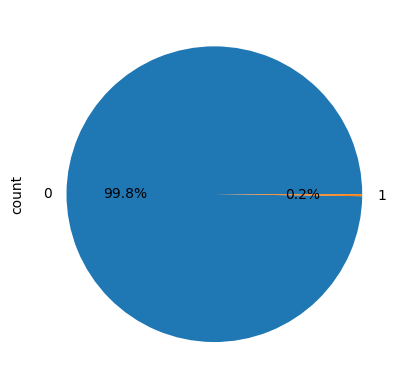

In [6]:
 df['Class'].value_counts().plot.pie(autopct='%1.1f%%')

In [9]:
featureCols = [col for col in df.columns if col !='id']

<Axes: >

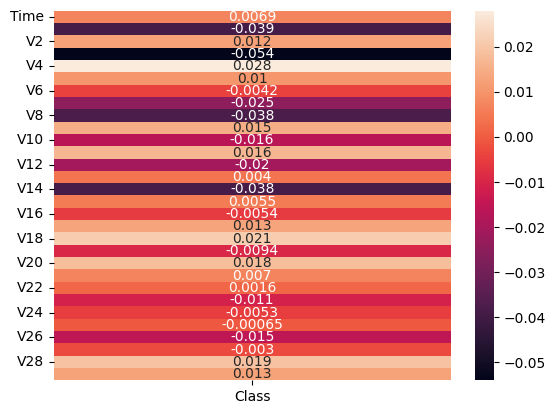

In [10]:
corr = df[featureCols].corr()
sns.heatmap(corr[['Class']].drop('Class'), annot=True)

In [12]:
y = df['Class'].values  # Binary labels (0/1)
X = df[[col for col in featureCols if col !='Class']]
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [14]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [15]:
train_ds = TabularDataset(X_train, y_train)
val_ds = TabularDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

In [29]:
## Training MLP as baseline model

In [30]:
# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [31]:
class TabularClassifier(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x).squeeze(-1)

model = TabularClassifier(num_features=30).to(device)

In [32]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 20

In [33]:
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in train_loader:

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item()
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss/len(val_loader):.4f}")

Epoch 1, Validation Loss: 0.0166
Epoch 2, Validation Loss: 0.0158
Epoch 3, Validation Loss: 0.0163
Epoch 4, Validation Loss: 0.0158
Epoch 5, Validation Loss: 0.0151
Epoch 6, Validation Loss: 0.0154
Epoch 7, Validation Loss: 0.0164
Epoch 8, Validation Loss: 0.0160
Epoch 9, Validation Loss: 0.0164
Epoch 10, Validation Loss: 0.0159
Epoch 11, Validation Loss: 0.0159
Epoch 12, Validation Loss: 0.0161
Epoch 13, Validation Loss: 0.0161
Epoch 14, Validation Loss: 0.0180
Epoch 15, Validation Loss: 0.0199
Epoch 16, Validation Loss: 0.0191
Epoch 17, Validation Loss: 0.0174
Epoch 18, Validation Loss: 0.0188
Epoch 19, Validation Loss: 0.0172
Epoch 20, Validation Loss: 0.0201


In [34]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        preds = model(X_batch)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

In [35]:
#f1 = f1_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_preds)
precision, recall, _ = precision_recall_curve(all_labels, all_preds)
pr_auc = auc(recall, precision)

In [36]:
print("ROC AUC : ",roc_auc, " PR AUC : ", pr_auc)

ROC AUC :  0.7158085570369432  PR AUC :  0.01896622358011164


### Baseline model ranks examples okay, but is failing to actually identify positives.

Need to focus on improving recall and precision for the minority class. Lets focus on fine tuning a transformer model for now. 

In [37]:
# Convert each row to a prompt
def row_to_prompt(row):
    return "Features: " + ", ".join([f"{col}={row[col]:.3f}" for col in featureCols if col != "Class"])

df["text"] = df.apply(row_to_prompt, axis=1)
df["label"] = df["Class"].astype(str)

In [38]:
df[['text','label']].head()

,text,label
0,"Features: Time=0.000, V1=2.074, V2=-0.129, V3=...",0
1,"Features: Time=0.000, V1=1.999, V2=-1.251, V3=...",0
2,"Features: Time=0.000, V1=0.092, V2=1.005, V3=-...",0
3,"Features: Time=0.000, V1=1.980, V2=-0.185, V3=...",0
4,"Features: Time=0.000, V1=1.026, V2=-0.172, V3=...",0


In [54]:


model_name = "distilbert-base-uncased"  # Can use any transformer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize
#def tokenize_fn(example):
    #return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

df.rename(columns={'Class':"labels"},inplace=True)


def tokenize_fn(example):
    # returns input_ids, attention_mask, and labels
    result = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    result["labels"] = example["labels"]  # pass labels along
    return result
dataset = datasets.Dataset.from_pandas(df[["text", "labels"]])
dataset = dataset.train_test_split(test_size=0.2)
dataset = dataset.map(tokenize_fn)

Map:   0%|          | 0/175303 [00:00<?, ? examples/s]

Map:   0%|          | 0/43826 [00:00<?, ? examples/s]

In [62]:

def tokenize_fn_v2(example):
    # returns input_ids, attention_mask, and labels
    result = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    return result

In [55]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# LoRA config
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_lin", "k_lin", "v_lin"],  # for attention layers
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)
model = get_peft_model(model, lora_config)
model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
for name, module in model.named_modules():
    print(name)


distilbert
distilbert.embeddings
distilbert.embeddings.word_embeddings
distilbert.embeddings.position_embeddings
distilbert.embeddings.LayerNorm
distilbert.embeddings.dropout
distilbert.transformer
distilbert.transformer.layer
distilbert.transformer.layer.0
distilbert.transformer.layer.0.attention
distilbert.transformer.layer.0.attention.dropout
distilbert.transformer.layer.0.attention.q_lin
distilbert.transformer.layer.0.attention.k_lin
distilbert.transformer.layer.0.attention.v_lin
distilbert.transformer.layer.0.attention.out_lin
distilbert.transformer.layer.0.sa_layer_norm
distilbert.transformer.layer.0.ffn
distilbert.transformer.layer.0.ffn.dropout
distilbert.transformer.layer.0.ffn.lin1
distilbert.transformer.layer.0.ffn.lin2
distilbert.transformer.layer.0.ffn.activation
distilbert.transformer.layer.0.output_layer_norm
distilbert.transformer.layer.1
distilbert.transformer.layer.1.attention
distilbert.transformer.layer.1.attention.dropout
distilbert.transformer.layer.1.attention.q

In [56]:

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available()  # Use mixed precision for speed
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=None  # Add your metrics if needed
)

trainer.train()

/tmp/ipykernel_1489/3198789585.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.010900,0.012782
2,0.014800,0.012593
3,0.009100,0.012874


/home/amod/miniconda3/envs/hflm/lib/python3.12/site-packages/peft/utils/other.py:1228: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 7e6beaeb-f385-414c-848a-37ebdf615b7f)') - silently ignoring the lookup for the file config.json in distilbert-base-uncased.
  warnings.warn(
/home/amod/miniconda3/envs/hflm/lib/python3.12/site-packages/peft/utils/save_and_load.py:286: UserWarning: Could not find a config file in distilbert-base-uncased - will assume that the vocabulary was not modified.
  warnings.warn(


TrainOutput(global_step=32871, training_loss=0.015149854379946204, metrics={'train_runtime': 6129.9567, 'train_samples_per_second': 85.793, 'train_steps_per_second': 5.362, 'total_flos': 1.7744945279007744e+16, 'train_loss': 0.015149854379946204, 'epoch': 3.0})

In [58]:
model.save_pretrained("./hfbinary/")

In [60]:
testdf = pd.read_csv('./data/test.csv')

testdf["text"] = testdf.apply(row_to_prompt, axis=1)
#testdf["labels"] = testdf["Class"]


In [67]:
dataset_test = datasets.Dataset.from_pandas(testdf[["text"]])

dataset_test = dataset_test.map(tokenize_fn_v2)

Map:   0%|          | 0/146087 [00:00<?, ? examples/s]

In [69]:
dataset_test.set_format(type="torch", columns=["input_ids", "attention_mask"])

In [73]:
test_loader = DataLoader(dataset_test, batch_size=32)


In [74]:
model.eval()
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        probs = F.softmax(outputs.logits, dim=-1)  # shape: [batch_size, num_classes]
        all_probs.extend(probs.cpu().numpy())


In [76]:
all_probs[:10]

[array([0.9982109 , 0.00178916], dtype=float32),
 array([9.9911863e-01, 8.8132435e-04], dtype=float32),
 array([9.9914241e-01, 8.5757254e-04], dtype=float32),
 array([0.99890554, 0.00109445], dtype=float32),
 array([9.9920529e-01, 7.9472555e-04], dtype=float32),
 array([0.99851626, 0.00148372], dtype=float32),
 array([9.9943966e-01, 5.6038389e-04], dtype=float32),
 array([0.99787605, 0.00212397], dtype=float32),
 array([0.9974738 , 0.00252619], dtype=float32),
 array([0.9986303 , 0.00136969], dtype=float32)]

In [81]:
label_1_probs = [p[1] for p in all_probs]

In [82]:
import matplotlib.pyplot as plt


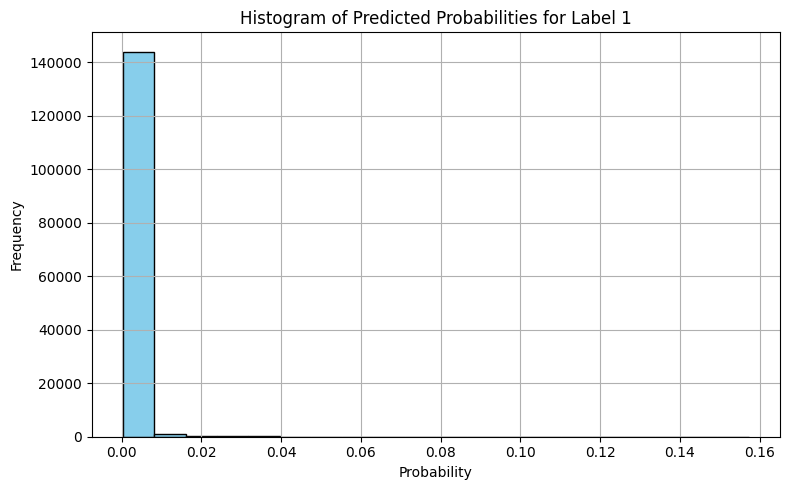

In [83]:
plt.figure(figsize=(8, 5))
plt.hist(label_1_probs, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of Predicted Probabilities for Label 1")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [88]:
eval_loss = [val['eval_loss'] for val in trainer.state.log_history if 'eval_loss' in val.keys()]
len(eval_loss)

3

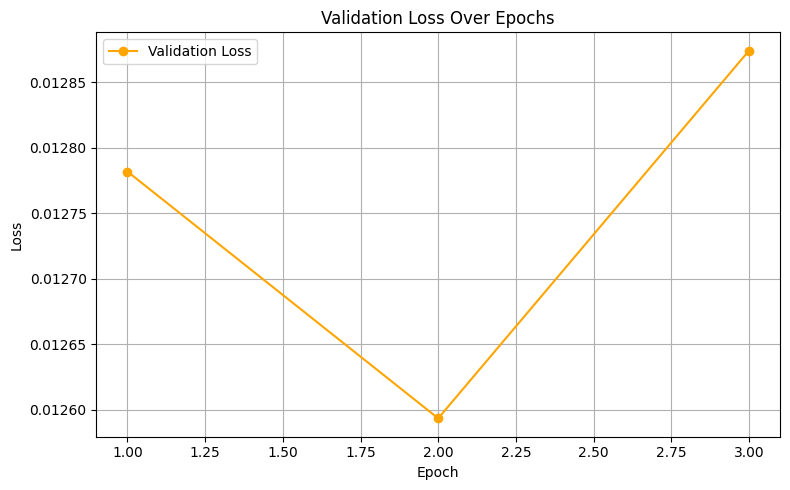

In [91]:
epochs = range(1, len(eval_loss) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, eval_loss, marker='o', linestyle='-', color='orange', label='Validation Loss')
plt.title("Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Transformer based model

In [92]:
class TabularTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_heads=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # [batch, seq_len=1, hidden]
        x = self.transformer(x)
        return self.classifier(x.squeeze(1))

In [94]:
df['labels'].value_counts()

labels
0    218660
1       469
Name: count, dtype: int64

In [95]:
218660/469

466.22601279317695

In [96]:
pos_weight = torch.tensor(466)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)



In [97]:
train_dataset = TabularDataset(X_train, y_train)
val_dataset = TabularDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

model = TabularTransformer(input_dim=30).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


/home/amod/miniconda3/envs/hflm/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [98]:
train_losses, val_losses, val_aucs = [], [], []

for epoch in range(10):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch).squeeze()
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch).squeeze()
            probs = torch.sigmoid(logits).cpu().numpy()
            val_preds.extend(probs)
            val_targets.extend(y_batch.numpy())

    val_loss = criterion(torch.tensor(val_preds), torch.tensor(val_targets)).item()
    val_auc = roc_auc_score(val_targets, val_preds)
    val_losses.append(val_loss)
    val_aucs.append(val_auc)

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_loss:.4f}, Val AUC={val_auc:.4f}")

Epoch 1: Train Loss=1.3710, Val Loss=1.4394, Val AUC=0.7437
Epoch 2: Train Loss=1.2733, Val Loss=1.4663, Val AUC=0.6740
Epoch 3: Train Loss=1.2811, Val Loss=1.4748, Val AUC=0.6193
Epoch 4: Train Loss=1.3227, Val Loss=1.4907, Val AUC=0.5644
Epoch 5: Train Loss=1.3717, Val Loss=1.4890, Val AUC=0.5111
Epoch 6: Train Loss=1.3643, Val Loss=1.4831, Val AUC=0.5714
Epoch 7: Train Loss=1.3744, Val Loss=1.5000, Val AUC=0.5449
Epoch 8: Train Loss=1.3758, Val Loss=1.4906, Val AUC=0.5692
Epoch 9: Train Loss=1.3744, Val Loss=1.4809, Val AUC=0.5954
Epoch 10: Train Loss=1.3745, Val Loss=1.4964, Val AUC=0.4522


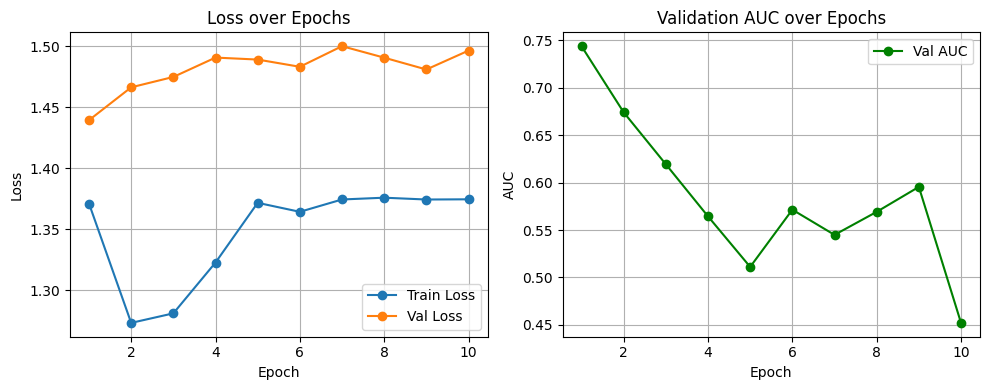

In [99]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Val Loss", marker='o')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_aucs, label="Val AUC", marker='o', color='green')
plt.title("Validation AUC over Epochs")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [122]:
from torch.utils.data import WeightedRandomSampler

class_weights = 1.0 / np.bincount(y_train.astype(int))
sample_weights = [class_weights[int(label)] for label in y_train]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32)

In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: raw logits from model
        # targets: binary labels (0 or 1)
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # pt = sigmoid probability of correct class
        focal_term = self.alpha * (1 - pt) ** self.gamma
        loss = focal_term * BCE_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [121]:
criterion = FocalLoss(alpha=25.0, gamma=2.0)


In [104]:
train_losses, val_losses, val_aucs = [], [], []

for epoch in range(10):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch).squeeze()
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch).squeeze()
            probs = torch.sigmoid(logits).cpu().numpy()
            val_preds.extend(probs)
            val_targets.extend(y_batch.numpy())

    val_loss = criterion(torch.tensor(val_preds), torch.tensor(val_targets)).item()
    val_auc = roc_auc_score(val_targets, val_preds)
    val_losses.append(val_loss)
    val_aucs.append(val_auc)

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_loss:.4f}, Val AUC={val_auc:.4f}")

Epoch 1: Train Loss=4.2951, Val Loss=9.1571, Val AUC=0.6982
Epoch 2: Train Loss=3.9629, Val Loss=9.1515, Val AUC=0.7321
Epoch 3: Train Loss=3.7200, Val Loss=9.0119, Val AUC=0.7396
Epoch 4: Train Loss=3.6812, Val Loss=8.5615, Val AUC=0.7291
Epoch 5: Train Loss=3.6261, Val Loss=8.7300, Val AUC=0.7637
Epoch 6: Train Loss=3.5867, Val Loss=8.6857, Val AUC=0.7502
Epoch 7: Train Loss=3.6135, Val Loss=8.9131, Val AUC=0.7672
Epoch 8: Train Loss=3.5410, Val Loss=8.9190, Val AUC=0.7733
Epoch 9: Train Loss=3.5275, Val Loss=8.6609, Val AUC=0.7938
Epoch 10: Train Loss=3.5452, Val Loss=8.7483, Val AUC=0.7574


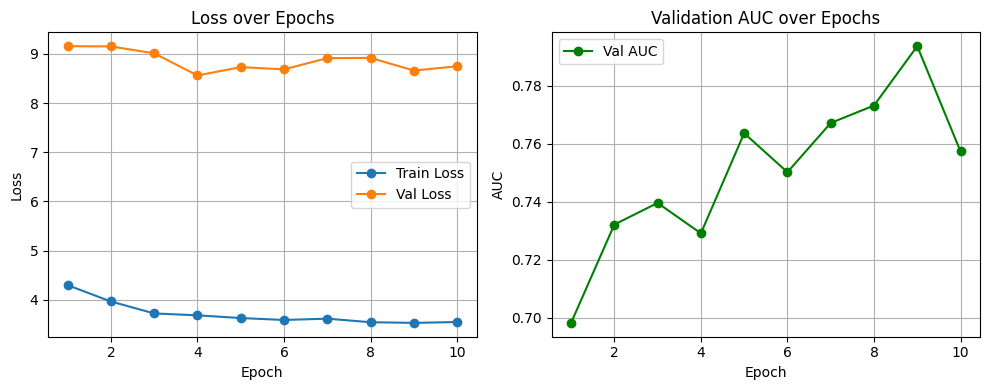

In [105]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Val Loss", marker='o')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_aucs, label="Val AUC", marker='o', color='green')
plt.title("Validation AUC over Epochs")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Attention weights 

In [106]:
class TabularTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_heads=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(hidden_dim, 1)
        self.attn_weights = None

        # Register hook to capture attention weights
        def hook(module, input, output):
            self.attn_weights = module.self_attn.attn_output_weights.detach()

        self.encoder_layer.self_attn.register_forward_hook(hook)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # [batch, seq_len=1, hidden]
        x = self.transformer(x)
        return self.classifier(x.squeeze(1))

In [107]:
model = TabularTransformer(input_dim=30).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/home/amod/miniconda3/envs/hflm/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [112]:
train_losses, val_losses, val_aucs = [], [], []

for epoch in range(10):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch).squeeze()
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch).squeeze()
            probs = torch.sigmoid(logits).cpu().numpy()
            val_preds.extend(probs)
            val_targets.extend(y_batch.numpy())

    val_loss = criterion(torch.tensor(val_preds), torch.tensor(val_targets)).item()
    val_auc = roc_auc_score(val_targets, val_preds)
    val_losses.append(val_loss)
    val_aucs.append(val_auc)

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_loss:.4f}, Val AUC={val_auc:.4f}")

Epoch 1: Train Loss=1.3039, Val Loss=5.2517, Val AUC=0.7524
Epoch 2: Train Loss=0.4326, Val Loss=4.9075, Val AUC=0.7510
Epoch 3: Train Loss=0.2961, Val Loss=4.7931, Val AUC=0.6884
Epoch 4: Train Loss=0.2505, Val Loss=5.1286, Val AUC=0.6531
Epoch 5: Train Loss=0.2056, Val Loss=4.8304, Val AUC=0.7301
Epoch 6: Train Loss=0.1733, Val Loss=4.7702, Val AUC=0.7206
Epoch 7: Train Loss=0.1566, Val Loss=4.8917, Val AUC=0.7021
Epoch 8: Train Loss=0.1475, Val Loss=5.0918, Val AUC=0.7352
Epoch 9: Train Loss=0.1459, Val Loss=4.7090, Val AUC=0.7070
Epoch 10: Train Loss=0.1340, Val Loss=4.7975, Val AUC=0.7287


In [113]:
import torch
import torch.nn as nn

class FeatureWiseTransformer(nn.Module):
    def __init__(self, num_features, hidden_dim=64, num_heads=4, num_layers=2):
        super().__init__()
        self.num_features = num_features

        # Embed each feature (1D → hidden_dim)
        self.feature_embedding = nn.Linear(1, hidden_dim)

        # Positional encoding to distinguish feature order
        self.positional_encoding = nn.Parameter(torch.randn(num_features, hidden_dim))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Binary classification
        )

    def forward(self, x):
        # x shape: [batch_size, num_features]
        x = x.unsqueeze(-1)  # → [batch_size, num_features, 1]
        x = self.feature_embedding(x)  # → [batch_size, num_features, hidden_dim]

        # Add positional encoding
        x = x + self.positional_encoding  # Broadcasted over batch

        # Transformer processes feature sequence
        x = self.transformer(x)  # → [batch_size, num_features, hidden_dim]

        # Aggregate features (mean pooling)
        x = x.mean(dim=1)  # → [batch_size, hidden_dim]

        return self.classifier(x).squeeze(-1)  # → [batch_size]

In [118]:
class_weights = 1.0 / np.bincount(y_train.astype(int))
sample_weights = [class_weights[int(label)] for label in y_train]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32)
model = FeatureWiseTransformer(num_features=30).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [119]:
train_losses, val_losses, val_aucs = [], [], []

for epoch in range(10):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch).squeeze()
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch).squeeze()
            probs = torch.sigmoid(logits).cpu().numpy()
            val_preds.extend(probs)
            val_targets.extend(y_batch.numpy())

    val_loss = criterion(torch.tensor(val_preds), torch.tensor(val_targets)).item()
    val_auc = roc_auc_score(val_targets, val_preds)
    val_losses.append(val_loss)
    val_aucs.append(val_auc)

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_loss:.4f}, Val AUC={val_auc:.4f}")

Epoch 1: Train Loss=2.7400, Val Loss=7.2962, Val AUC=0.8127
Epoch 2: Train Loss=1.6814, Val Loss=5.8716, Val AUC=0.7876
Epoch 3: Train Loss=1.2219, Val Loss=5.3834, Val AUC=0.8130
Epoch 4: Train Loss=1.0288, Val Loss=5.9366, Val AUC=0.7847
Epoch 5: Train Loss=0.8963, Val Loss=5.0947, Val AUC=0.7886
Epoch 6: Train Loss=0.8087, Val Loss=4.9625, Val AUC=0.7972
Epoch 7: Train Loss=0.7297, Val Loss=5.1236, Val AUC=0.7945
Epoch 8: Train Loss=0.6606, Val Loss=5.0993, Val AUC=0.7975
Epoch 9: Train Loss=0.6331, Val Loss=5.0105, Val AUC=0.7766
Epoch 10: Train Loss=0.6076, Val Loss=5.0846, Val AUC=0.7788


In [135]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomTransformerEncoderLayer(nn.TransformerEncoderLayer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.attn_weights = None

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # Self-attention with weights
        attn_output, attn_weights = self.self_attn(
            src, src, src,
            attn_mask=src_mask,
            key_padding_mask=src_key_padding_mask,
            need_weights=True,
            average_attn_weights=False
        )
        self.attn_weights = attn_weights  # [batch_size, num_heads, seq_len, seq_len]

        # Residual + LayerNorm
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)

        # Feedforward block
        ff_output = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = src + self.dropout2(ff_output)
        src = self.norm2(src)

        return src

In [136]:
class FeatureWiseTransformer(nn.Module):
    def __init__(self, num_features, hidden_dim=64, num_heads=4, num_layers=2):
        super().__init__()
        self.num_features = num_features

        self.feature_embedding = nn.Linear(1, hidden_dim)
        self.positional_encoding = nn.Parameter(torch.randn(num_features, hidden_dim))

        # Stack custom encoder layers
        self.encoder_layers = nn.ModuleList([
            CustomTransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, batch_first=True)
            for _ in range(num_layers)
        ])

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # x shape: [batch_size, num_features]
        x = x.unsqueeze(-1)  # → [batch_size, num_features, 1]
        x = self.feature_embedding(x) + self.positional_encoding  # → [batch_size, num_features, hidden_dim]

        for layer in self.encoder_layers:
            x = layer(x)

        x = x.mean(dim=1)
        return self.classifier(x).squeeze(-1)

    def get_attention_maps(self):
        # Returns list of attention maps from each layer
        return [layer.attn_weights for layer in self.encoder_layers]

In [137]:
class_weights = 1.0 / np.bincount(y_train.astype(int))
sample_weights = [class_weights[int(label)] for label in y_train]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32)
model = FeatureWiseTransformer(num_features=30).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [138]:
train_losses, val_losses, val_aucs = [], [], []

for epoch in range(10):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch).squeeze()
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch).squeeze()
            probs = torch.sigmoid(logits).cpu().numpy()
            val_preds.extend(probs)
            val_targets.extend(y_batch.numpy())

    val_loss = criterion(torch.tensor(val_preds), torch.tensor(val_targets)).item()
    val_auc = roc_auc_score(val_targets, val_preds)
    val_losses.append(val_loss)
    val_aucs.append(val_auc)

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_loss:.4f}, Val AUC={val_auc:.4f}")

Epoch 1: Train Loss=2.5448, Val Loss=5.6507, Val AUC=0.7768
Epoch 2: Train Loss=1.5180, Val Loss=6.3105, Val AUC=0.7961
Epoch 3: Train Loss=1.1524, Val Loss=5.4220, Val AUC=0.7635
Epoch 4: Train Loss=0.9459, Val Loss=5.4157, Val AUC=0.7684
Epoch 5: Train Loss=0.8426, Val Loss=5.4896, Val AUC=0.7749
Epoch 6: Train Loss=0.7605, Val Loss=5.0953, Val AUC=0.7818
Epoch 7: Train Loss=0.6930, Val Loss=5.3913, Val AUC=0.7802
Epoch 8: Train Loss=0.6536, Val Loss=4.8860, Val AUC=0.7842
Epoch 9: Train Loss=0.6104, Val Loss=5.1296, Val AUC=0.7838
Epoch 10: Train Loss=0.5841, Val Loss=5.2803, Val AUC=0.7680


In [139]:
model.eval()
sample = torch.tensor(X_val[0], dtype=torch.float32).unsqueeze(0).to(device)

with torch.no_grad():
    _ = model(sample)

# Access attention weights from each layer
# Each entry: [batch_size, num_heads, num_features, num_features]
attn_maps = [layer.attn_weights for layer in model.encoder_layers]



In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_map(attn_tensor, feature_names=None, layer=0, head=0):
    """
    attn_tensor: [batch_size, num_heads, num_features, num_features]
    feature_names: list of feature labels
    """
    attn = attn_tensor[0, head].cpu().numpy()  # First sample, selected head

    if feature_names is None:
        feature_names = [f"F{i}" for i in range(attn.shape[0])]

    plt.figure(figsize=(10, 8))
    sns.heatmap(attn, xticklabels=feature_names, yticklabels=feature_names,
                cmap="viridis", annot=True, fmt=".2f")
    plt.title(f"Attention Map — Layer {layer}, Head {head}")
    plt.xlabel("Attended Feature")
    plt.ylabel("Query Feature")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [146]:
def plot_aggregated_attention(attn_maps, feature_names=None):
    # Stack and average: [num_layers, batch_size, num_heads, F, F]
    stacked = torch.stack(attn_maps)
    avg_attn = stacked.mean(dim=(0, 1, 2))  # [F, F]
    plt.figure(figsize=(10, 8))
    sns.heatmap(avg_attn.cpu().numpy(), xticklabels=feature_names, yticklabels=feature_names,
                cmap="magma", annot=True, fmt=".2f")
    plt.title("Aggregated Attention Across All Layers & Heads")
    plt.xlabel("Attended Feature")
    plt.ylabel("Query Feature")
    plt.tight_layout()
    plt.show()

In [149]:
def compare_layers(model, feature_names=None):
    attn_maps = model.get_attention_maps()
    for i, attn_tensor in enumerate(attn_maps):
        for h in range(attn_tensor.shape[1]):  # num_heads
            plot_attention_map(attn_tensor, feature_names, layer=i, head=h)

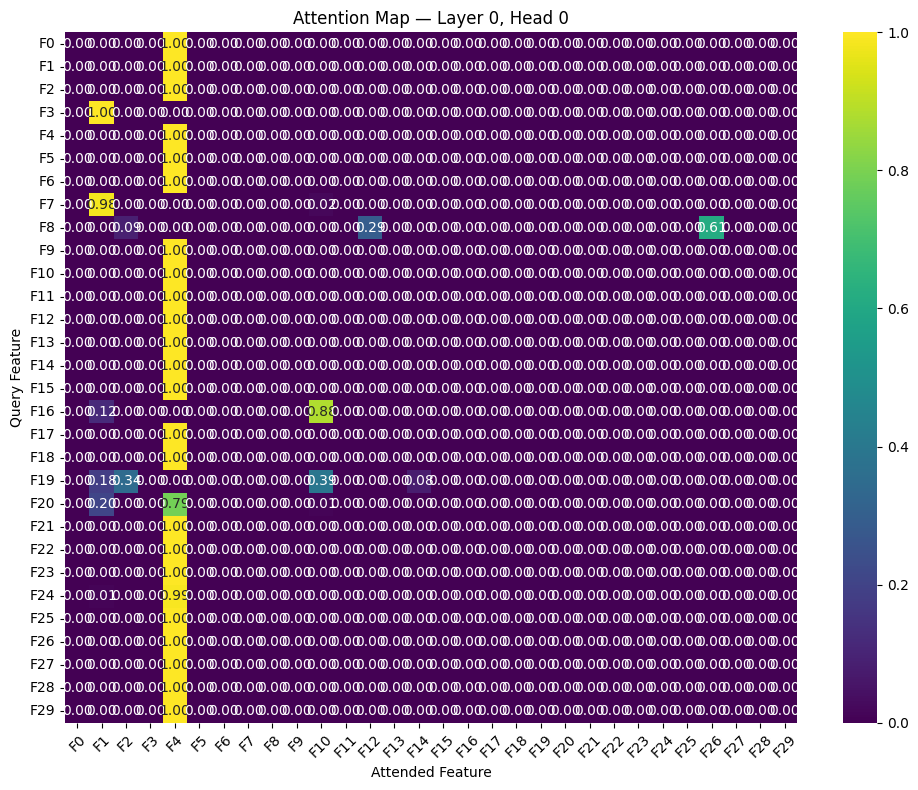

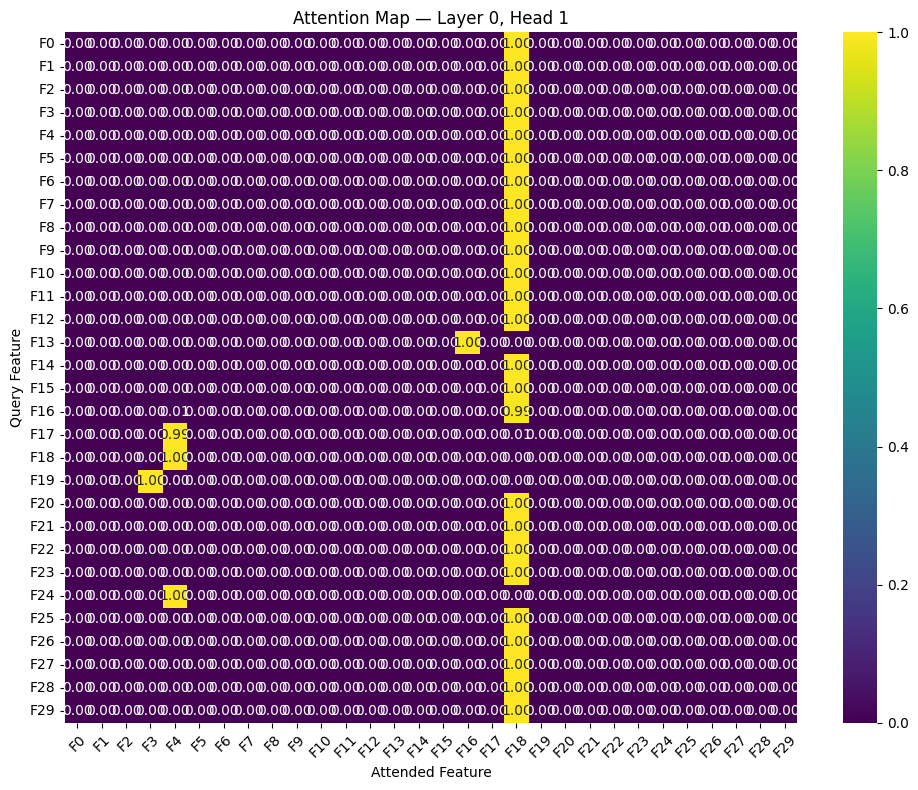

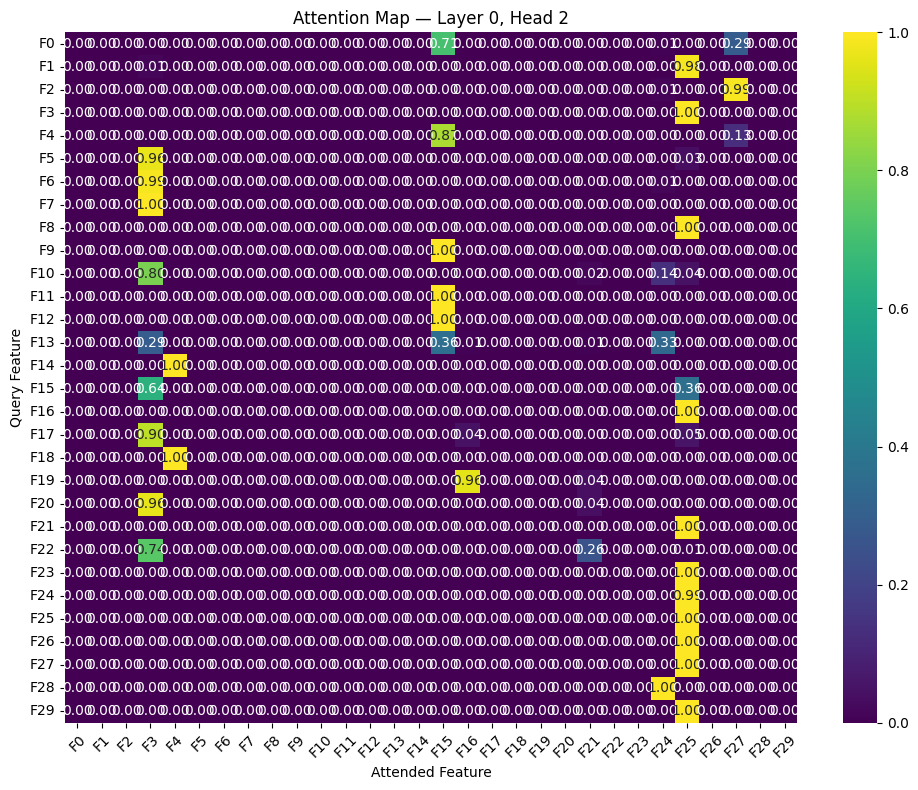

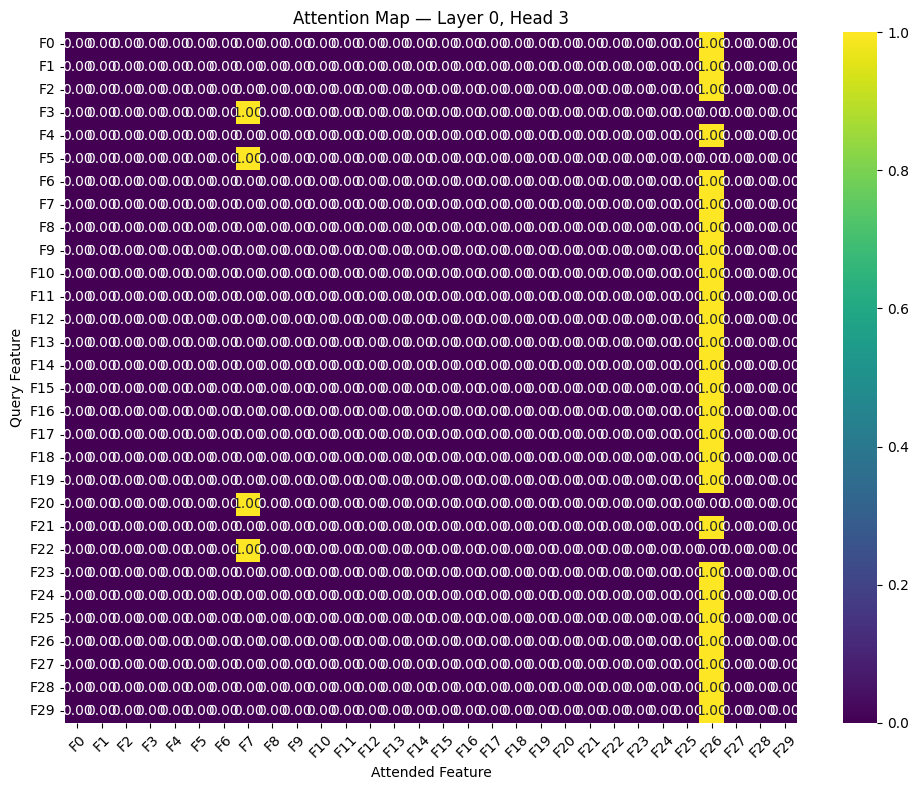

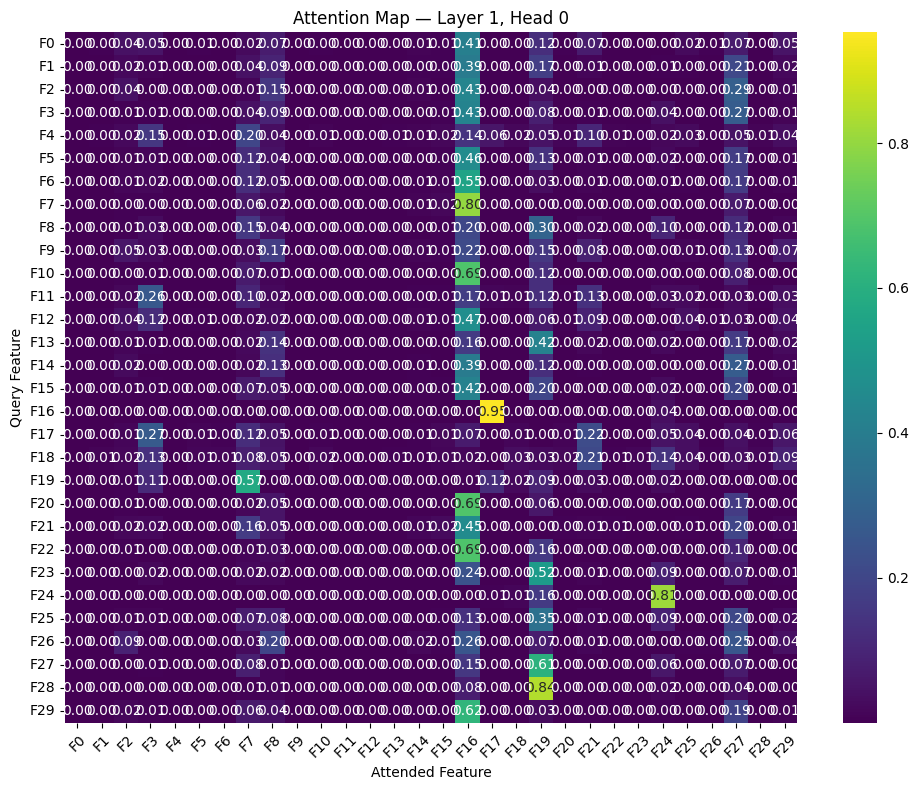

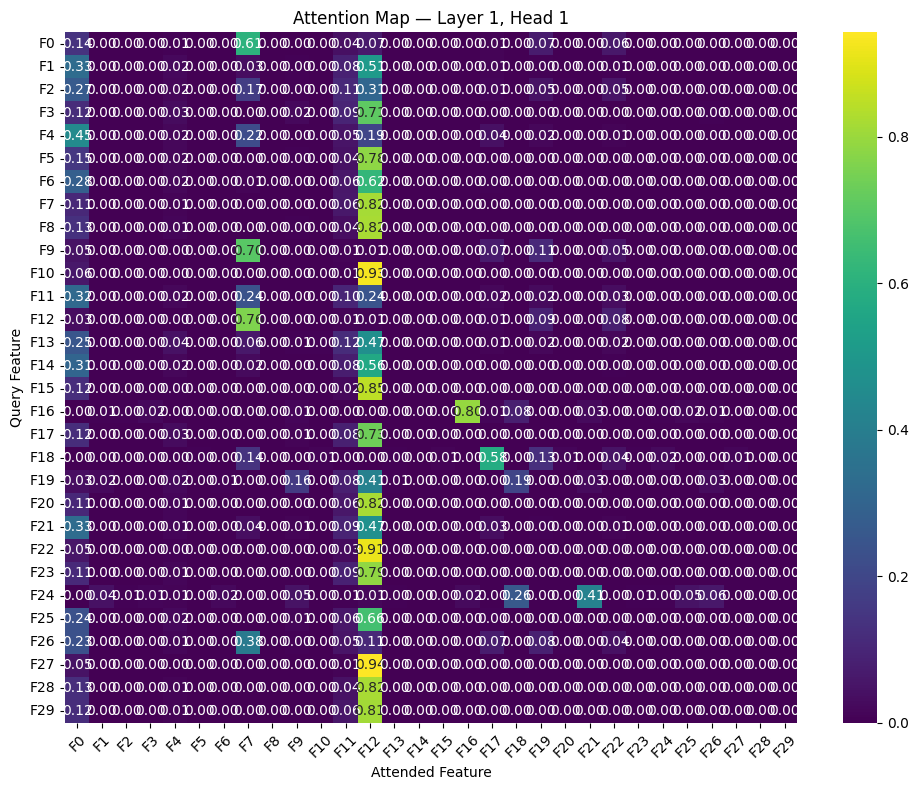

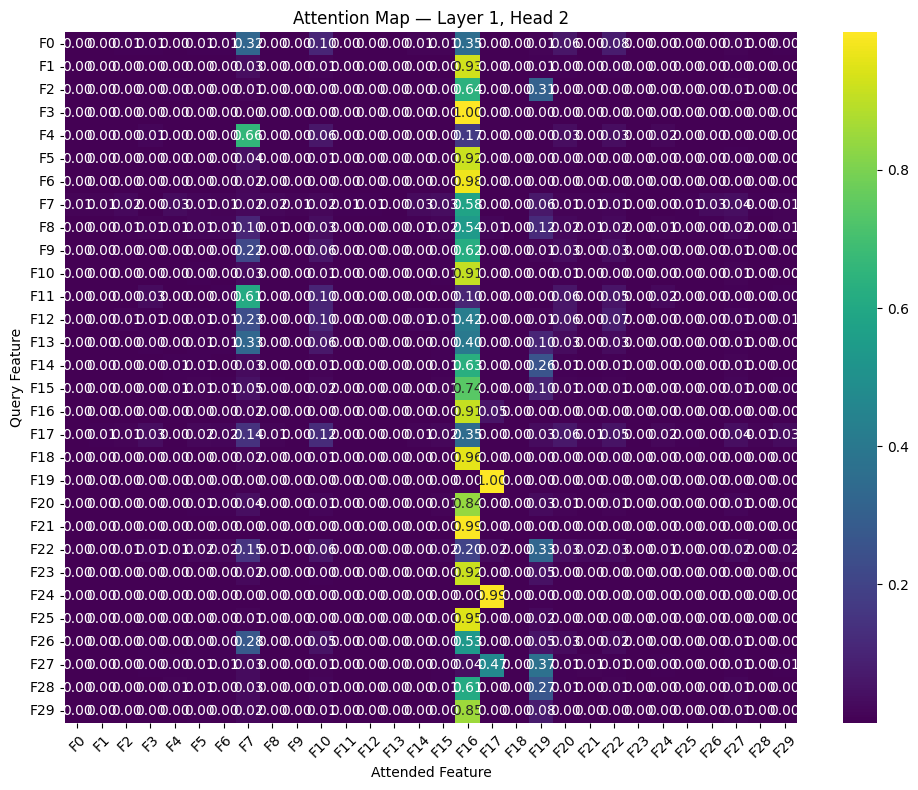

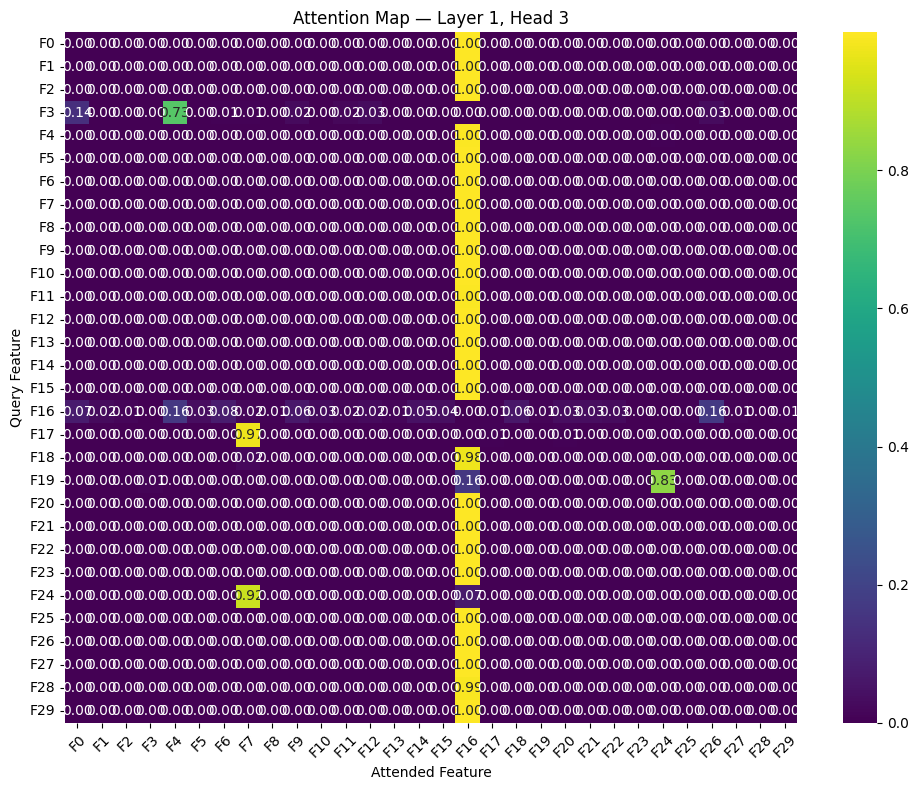

In [150]:
compare_layers(model)

In [151]:
def compare_samples(model, samples, feature_names=None):
    for i, sample in enumerate(samples):
        model.eval()
        with torch.no_grad():
            _ = model(sample.unsqueeze(0).to(next(model.parameters()).device))
        attn_maps = model.get_attention_maps()
        print(f"\n🧪 Sample {i}")
        for layer_idx, attn_tensor in enumerate(attn_maps):
            plot_attention_map(attn_tensor, feature_names, layer=layer_idx, head=0)

In [157]:
samples = [
    torch.tensor(X_val[0], dtype=torch.float32),
    torch.tensor(X_val[10], dtype=torch.float32),
    torch.tensor(X_val[635], dtype=torch.float32),
    torch.tensor(X_val[2210], dtype=torch.float32)
]


🧪 Sample 0


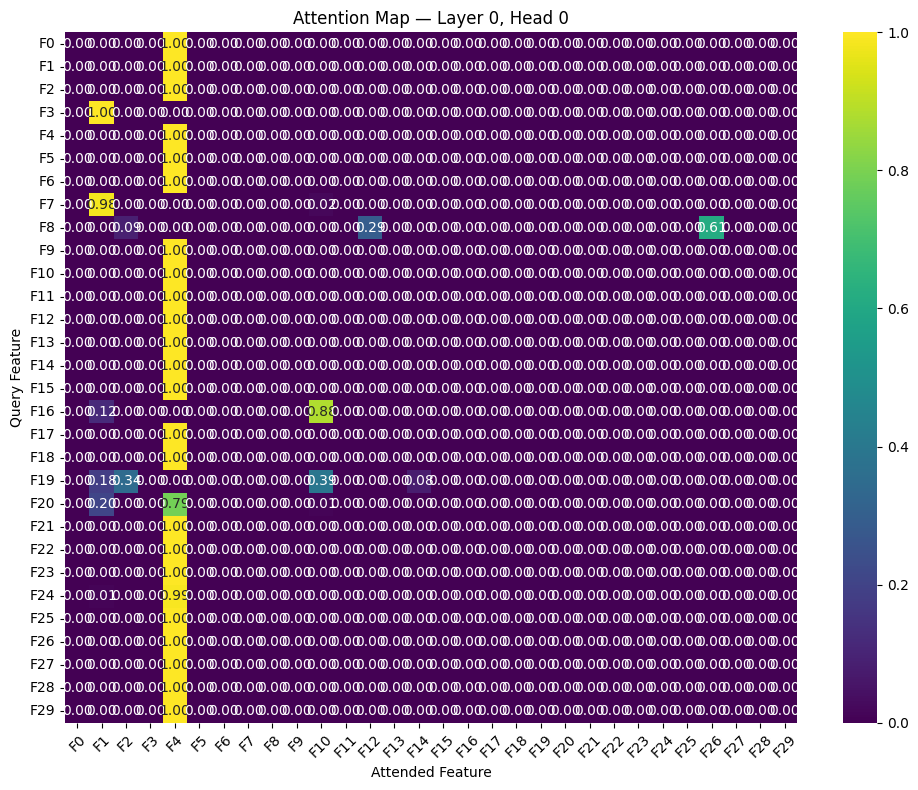

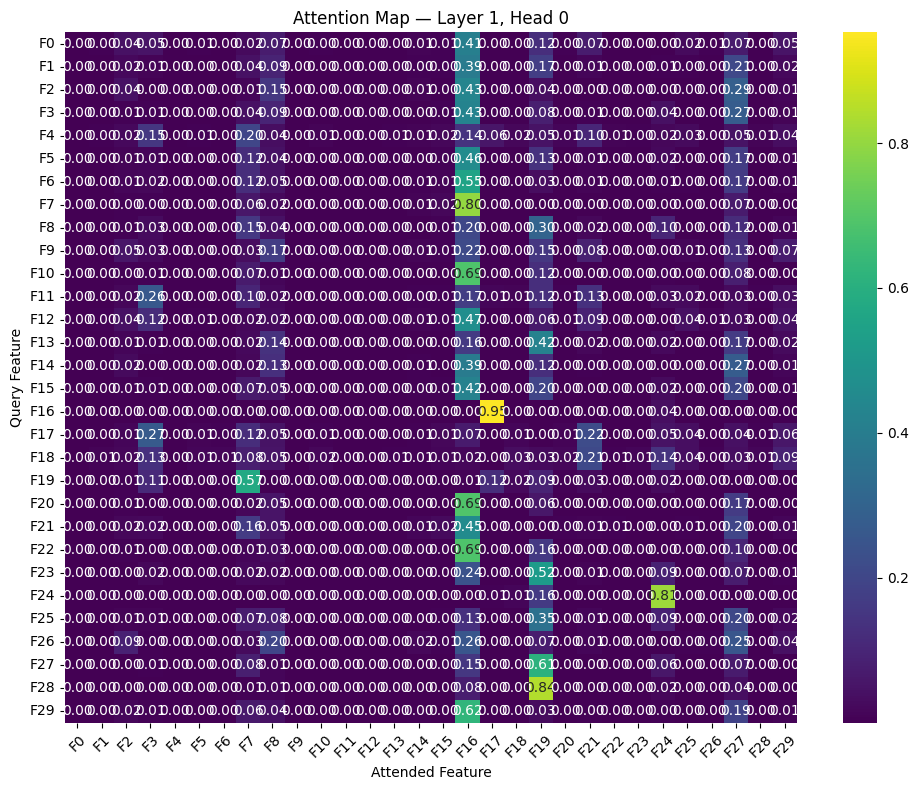


🧪 Sample 1


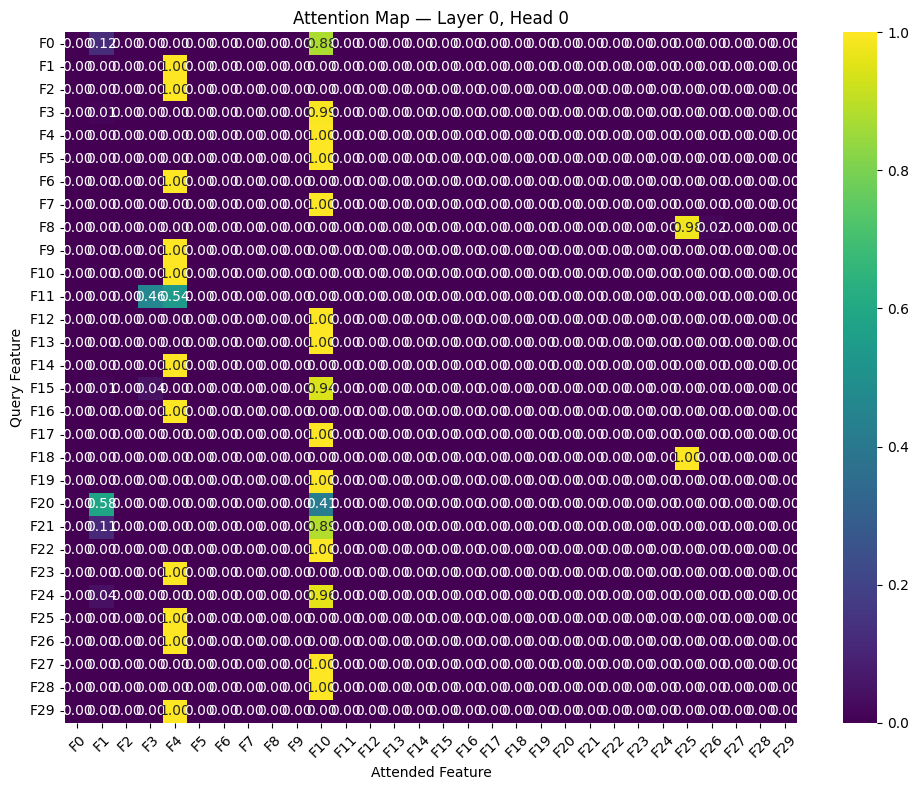

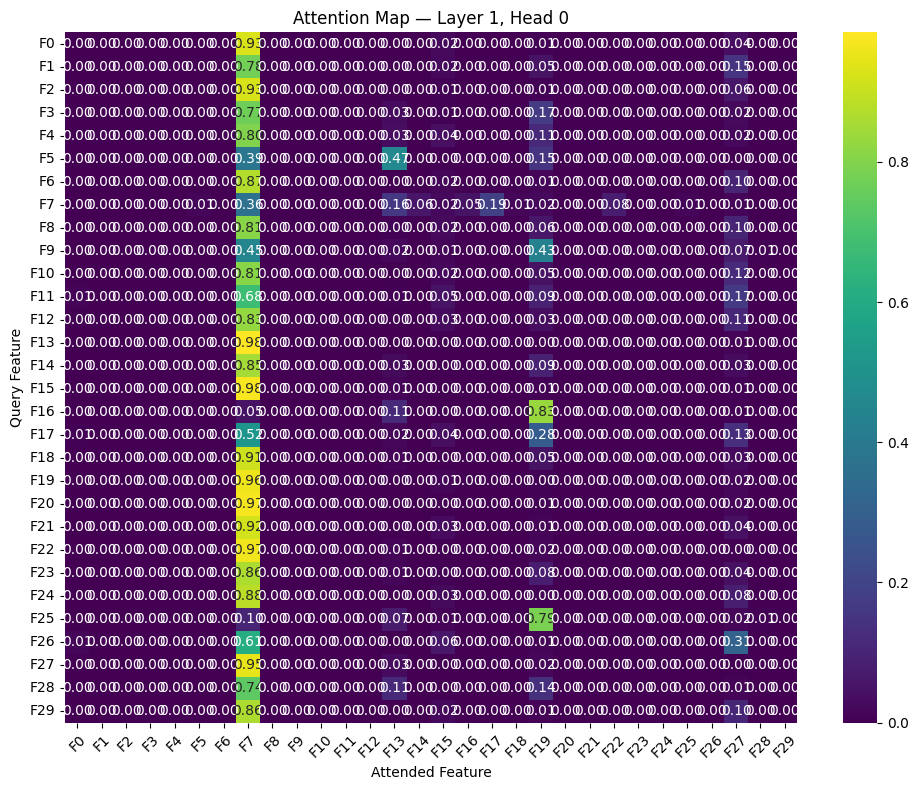


🧪 Sample 2


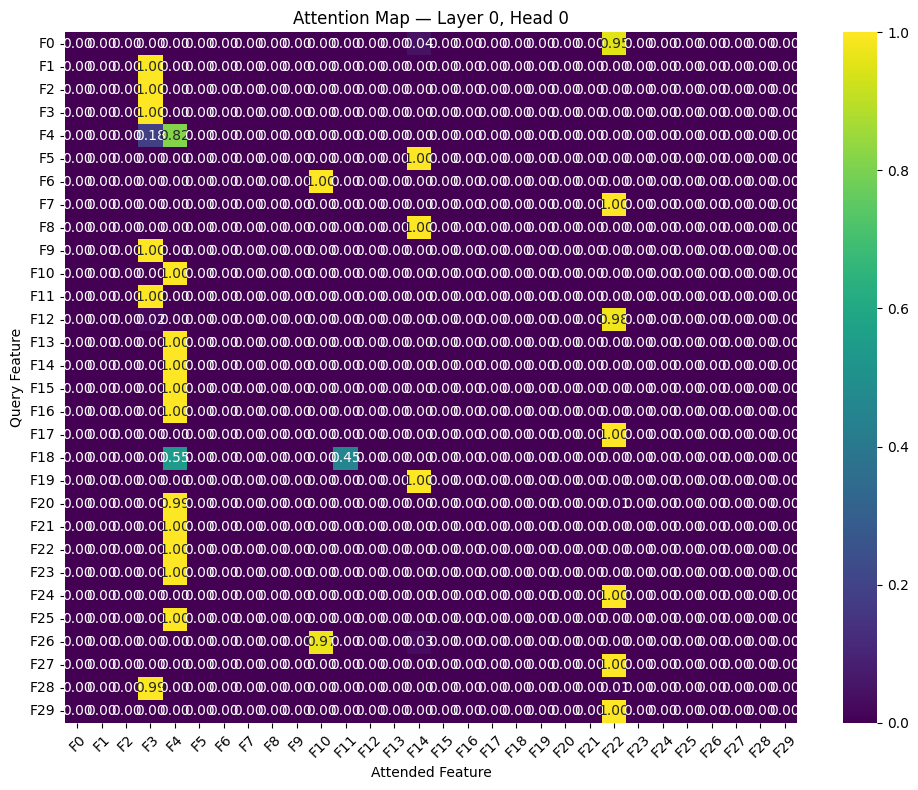

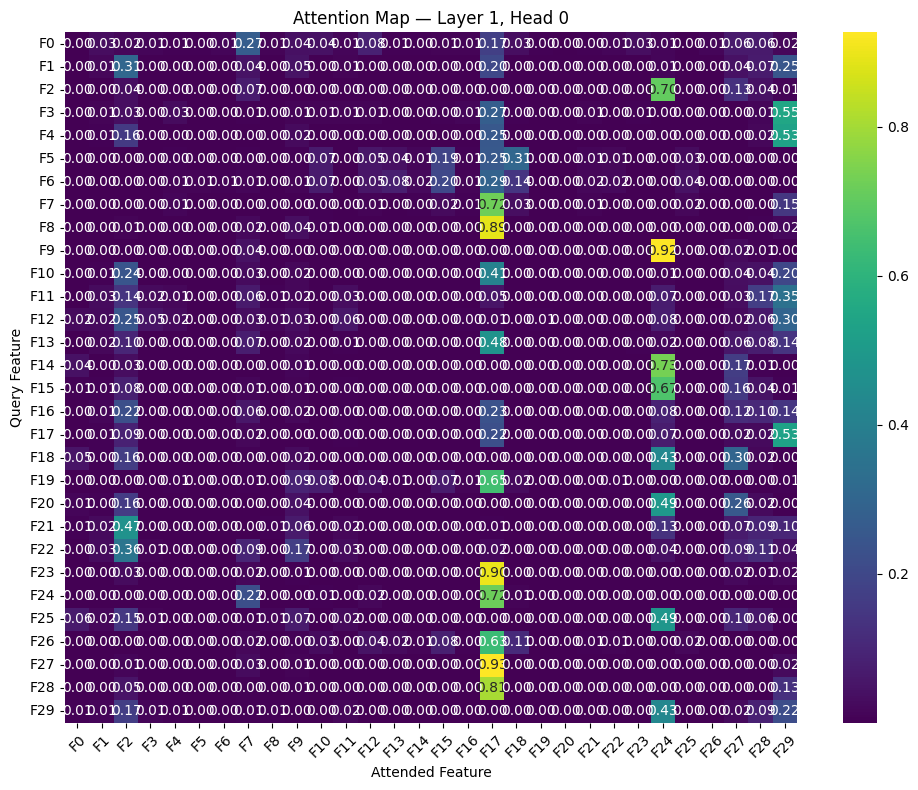


🧪 Sample 3


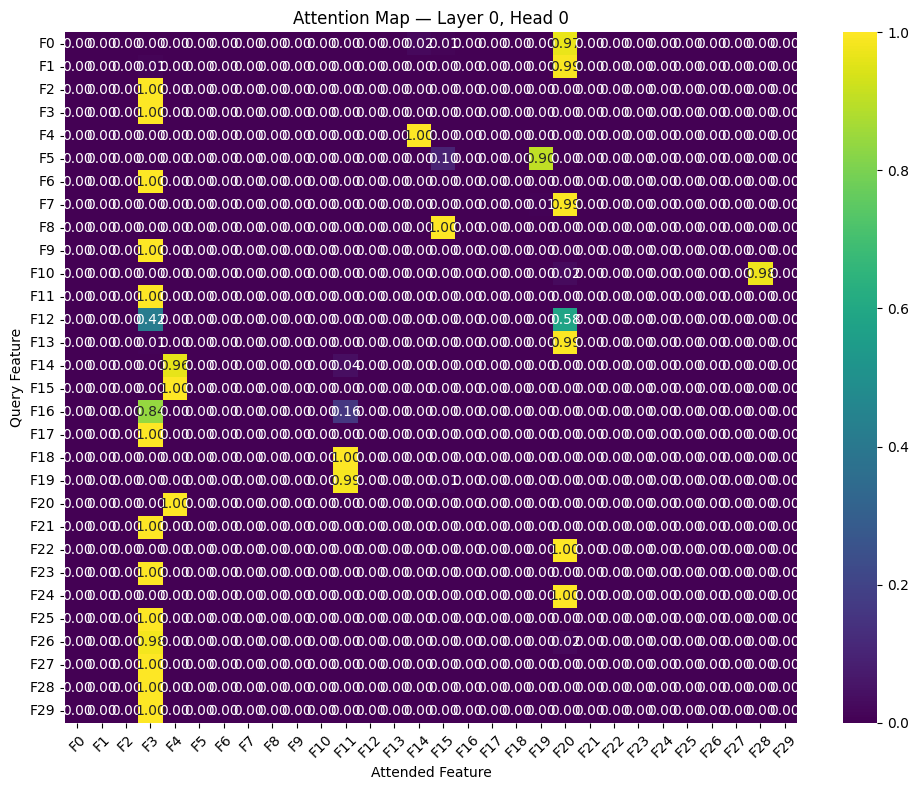

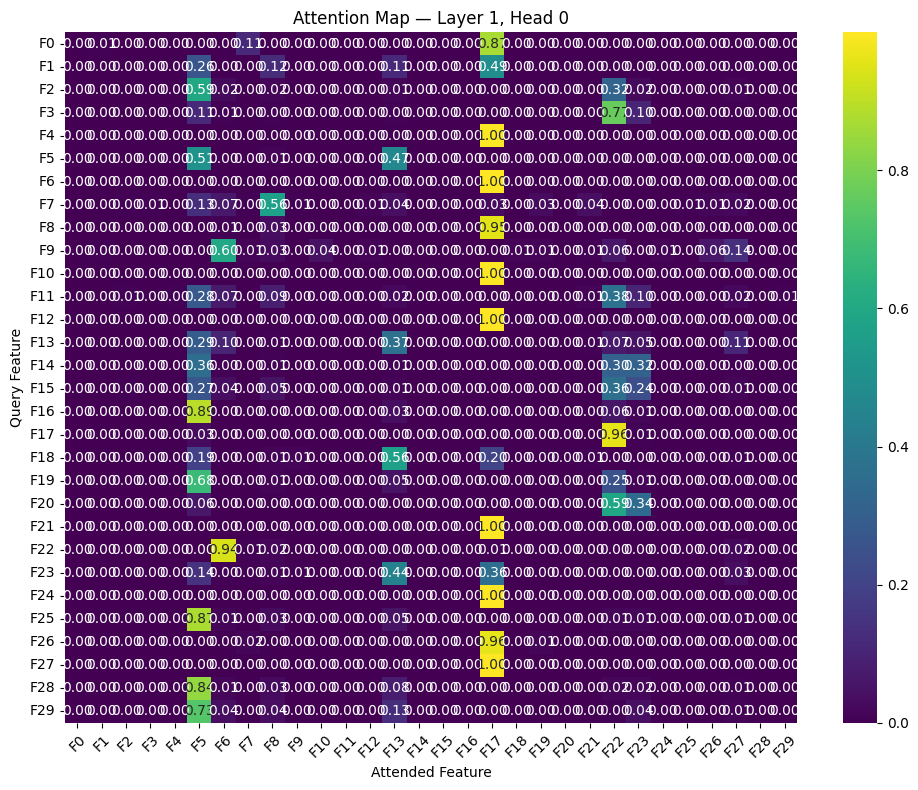

In [158]:
compare_samples(model,samples)